In [182]:
# !pip install shap
# !pip install lightfm
# !pip install catboost
# !pip install pyarrow

# 0. Configuration

In [183]:
INTERACTIONS_PATH = 'https://drive.google.com/file/d/1UaHkTsdvKP6SbI99QJPsUkmVtEA5vcBr/view?usp=share_link'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/1stVBgXzUNGtSKW02vpexLreiXlyf34yx/view?usp=share_link'
INTERACTIONS_MERGED_PATH = 'https://drive.google.com/file/d/1ikzQlQLKqUZxG36S5pvr33am0pkL7TVy/view?usp=share_link'

# 1. Modules and functions

In [184]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import ast
import shap
import numpy as np
import pandas as pd
import datetime as dt

from typing import List

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from lightfm.data import Dataset
from lightfm import LightFM
import lightgbm as lgb

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

# from google.colab import drive
# drive.mount('/content/drive')

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. 1. Helper functions to avoid copy paste

In [185]:
def convert_to_list_type(data: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    for col in columns:
        data[col] = data[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return data


In [186]:
def read_parquet_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_parquet(file_path, engine='pyarrow')

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion:

In [187]:
# interactions data
interactions = read_parquet_from_gdrive(INTERACTIONS_PATH)
interactions.sample(5)

,year,month,day,user_id,movie_id,watch_duration_minutes
776583,2022,11,9,239438050,fbc33563-88d0-464c-a517-2f1bf3bae0e1,75.100
487382,2022,10,25,228143214,80a34904-2a75-4d40-a77b-db120e68b2b9,0.100
1012537,2022,11,21,228279085,4fd7d857-4718-4e72-bff6-6448d2cd0a1e,9.900
345279,2022,10,18,23385727,fd0134c9-031f-4fad-84db-cd6d515760c6,30.267
1613105,2022,12,21,238851289,56c278aa-39f4-4ccf-a95a-050f70d1445d,71.983


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [188]:
# information about films etc
movies_metadata = read_parquet_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.sample(5)

,movie_id,title,entity_type,genres,actors,director,country,release_world,age_rating,duration
221149,213742e7-f17c-4f6b-9dc6-dd9895f94b4e,Чудо-дино из школы Эр,Сезон,"[Комедии, Мультфильмы]",[-],"[Чжао Ляньхуа, Чжан Шеньсян]",[Китай],None,6.000,NaN
94359,ad5c8ff3-5608-4f30-bd58-b3c0b4b9bd7f,Близкая угроза,Сериал,None,None,None,None,None,NaN,0.000
73684,57158b4c-aec4-4c70-8dfe-25fef33a3b6d,Бруклин 9-9,Серия,"[Криминальное, Комедии]","[Энди Сэмберг, Андре Брауэр, Терри Крюс, Стефа...","[Майкл МакДональд, Дин Холлэнд, Линда Мендоса]",[США],2013-09-17,18.000,22.000
96879,8df799b2-2286-4969-b7bf-e9645e0d3bc5,Тобол,Серия,"[Историческое, Драмы]","[Евгений Дятлов, Дмитрий Дюжев, Дмитрий Назаро...",[Игорь Зайцев],[Россия],2019-03-01,18.000,57.000
154659,05c60117-d576-4cfd-ba78-d2d4c87ca4b8,Султан Разия,Серия,"[Боевики, Историческое, Биографии, Драмы]","[Панкури Авастхи, Рия Дипси, Анкит Арора, Сура...","[Ариф Али Ансари, Хаснан Хидерабадвала]",[Индия],2015-02-01,12.000,21.000


In [189]:
# Не запускалось через ссылку)))
interactions_merged = pd.read_parquet('interactions_merged_1.parquet', engine='pyarrow')
interactions_merged.sample(5)

,year,month,day,user_id,movie_id,watch_duration_minutes,datetime,title,entity_type,genres,actors,director,country,release_world,age_rating,duration,watched_pct
933287,2022,11,17,211253884,cab51ef5-4458-45c1-9a5e-b8738b6298a2,0.500,2022-11-17,Белый слон,Фильм,"[Криминальное, Боевики, Триллеры]","[Брюс Уиллис, Джон Малкович, Майкл Рукер, Крис...",[Джесси Джонсон],[США],2022-06-03,18.000,92.000,0.543
1591787,2022,12,20,238805298,f5e92e8a-00c1-4b0c-804a-4a936097cb20,1.467,2022-12-20,Эмоджи фильм,Фильм,"[Семейное, Мультфильмы]","[Патрик Стюарт, ТиДжей Миллер, Майя Рудольф, А...",[Энтони Леондис],[США],2017-07-28,6.000,83.000,1.767
1655759,2022,12,23,23761707,dfc7e56e-1a1b-40fe-b902-a6561b46bfcc,92.200,2022-12-23,Монстры на каникулах 3: Море зовёт,Фильм,"[Семейное, Приключения, Комедии, Фэнтези, Муль...","[Стив Бушеми, Кэтрин Хан, Энди Сэмберг, Адам С...",[Генндий Тартаковский],[США],2018-06-13,6.000,98.000,94.082
976433,2022,11,19,1328799,2e964b6c-17b4-4c47-bdf4-5a044b667bb6,86.783,2022-11-19,Танки,Фильм,"[Военное, Приключения, Историческое]","[Андрей Мерзликин, Александр Тютин, Аглая Тара...",[Ким Дружинин],[Россия],2018-04-26,12.000,90.000,96.426
1254173,2022,12,3,238747035,0436e58d-2544-4328-a25d-f28b20b8dacf,64.917,2022-12-03,Стражи Галактики,Фильм,"[Боевики, Приключения, Фантастика]","[Зои Салдана, Вин Дизель, Брэдли Купер, Крис П...",[Джеймс Ганн],"[США, Великобритания]",2014-07-21,12.000,117.000,55.484


In [190]:
interactions_merged = interactions_merged[['user_id', 'movie_id', 'datetime', 'watch_duration_minutes', 'watched_pct']]
interactions_merged.sample(5)

,user_id,movie_id,datetime,watch_duration_minutes,watched_pct
64220,23306981,851671a2-de46-4426-afb6-57120ecab9f1,2022-10-04,47.817,57.610
1694660,23501174,b7cf945d-1f06-45c7-914b-f7ee0b16d2fb,2022-12-25,86.267,95.852
1667731,654276,2f15a7b8-7a2c-492f-80fa-06e245706de2,2022-12-24,64.400,75.765
536152,219506067,ee48def6-c311-4b73-a878-1a5d3d1679a3,2022-10-27,47.967,5.597
1255275,238775620,e76aa207-8b7b-4f6c-95cc-463db49ef2a1,2022-12-03,89.533,90.438


## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [191]:
# remove redundant data points
interactions_filtered = interactions_merged.loc[interactions_merged['watch_duration_minutes'] > 20].reset_index(drop = True)

In [192]:
print(interactions_merged.shape, interactions_filtered.shape)

(1800000, 5) (1143689, 5)


In [193]:
interactions_filtered['datetime'] = pd.to_datetime(interactions_filtered['datetime'])

In [194]:
# set dates params for filter
MAX_DATE = interactions_filtered['datetime'].max()
MIN_DATE = interactions_filtered['datetime'].min()
TEST_INTERVAL_DAYS = 14

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")

min date in filtered interactions: 2022-12-30 00:00:00
max date in filtered interactions:: 2022-10-01 00:00:00


In [195]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

In [196]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['datetime'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['datetime'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(952163, 5) (191526, 5)


In [197]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['datetime'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

2022-11-23 00:00:00


In [198]:
global_train = global_train.dropna().reset_index(drop = True)

In [199]:
local_train = global_train.loc[global_train['datetime'] < local_train_thresh]
local_test = global_train.loc[global_train['datetime'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(655837, 5) (296326, 5)


In [200]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(247109, 5)


In [201]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['movie_id'].unique())

In [202]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [203]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  86199
user features mapper length -  86199
movies mapper length -  12262
Users movie features mapper length -  12262


In [204]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [205]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [206]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'movie_id']]))

In [207]:
train_mat

<86199x12262 sparse matrix of type '<class 'numpy.int32'>'
	with 655837 stored elements in COOrdinate format>

In [208]:
train_mat_weights

<86199x12262 sparse matrix of type '<class 'numpy.float32'>'
	with 655837 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [209]:
# set params - last HW
# NO_COMPONENTS = 10
# LEARNING_RATE = .05
# LOSS = 'logistic'
# MAX_SAMPLED = 10
# RANDOM_STATE = 42
# EPOCHS = 10

# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [210]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [211]:
# execute training
for _ in tqdm_notebook(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [212]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 150513, row number in matrix - 72


In [213]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

12262

In [214]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([ 3.354821  ,  0.9085439 , -0.18029648, ..., -2.8115    ,
        -2.301799  , -2.6046305 ], dtype=float32),
 (12262,))

In [215]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 9910,     0,   325, 10939,  7861, 10946, 10938,    12, 11559,
        8597])

In [216]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['movie_id'], movies_metadata['title']))

In [217]:
recs = pd.DataFrame({'col_id': top_cols})
recs['movie_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['movie_id'].map(item_name_mapper)
recs

,col_id,movie_id,title
0,9910,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,Кунгур
1,0,91f9d892-a508-4962-91e9-abacd93e0830,1703
2,325,42f5cb31-f333-426c-a95b-8e106741de38,Вышка
3,10939,5a3bf8a0-3054-448b-b524-025abea0cac3,Аксентьев
4,7861,703b202e-1774-4b93-8a0c-e848d7d3abcc,Начать сначала
5,10946,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,Три тысячи лет желаний
6,10938,e5f48804-89a0-45d0-900b-5e88d465954f,Красная Шапочка
7,12,25ef7e77-d83d-46d1-999a-ca36a045ab9a,Химера
8,11559,ec0a8ccf-f614-4124-8fd3-dade8dace293,Суперпозиция
9,8597,28509b56-b1b5-4568-93d6-de7611ef5a2e,Лэйт Найт Скул


In [218]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][1000]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 219132313, row number in matrix - 671


In [219]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape


(array([ 2.6169252 , -0.20646223, -1.4186534 , ..., -2.2275174 ,
        -1.9879644 , -2.3659043 ], dtype=float32),
 (12262,))

In [220]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([    0, 10939,  9910,  6827,    65,    74, 10938,   216,  7861,
          12])

In [221]:
recs = pd.DataFrame({'col_id': top_cols})
recs['movie_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['movie_id'].map(item_name_mapper)
recs

,col_id,movie_id,title
0,0,91f9d892-a508-4962-91e9-abacd93e0830,1703
1,10939,5a3bf8a0-3054-448b-b524-025abea0cac3,Аксентьев
2,9910,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,Кунгур
3,6827,d722f09d-a99d-4c7f-853c-0c77fcd45f35,Барбоскины Team
4,65,537ece24-2358-4108-a419-85cfd5952607,Пес-самурай и город кошек
5,74,3cfb5023-3c07-4384-8acf-d488d5a0ffa4,Ворона
6,10938,e5f48804-89a0-45d0-900b-5e88d465954f,Красная Шапочка
7,216,37957168-d3fe-4273-89ee-f59a3a1d7c14,Кощей. Похититель невест
8,7861,703b202e-1774-4b93-8a0c-e848d7d3abcc,Начать сначала
9,12,25ef7e77-d83d-46d1-999a-ca36a045ab9a,Химера


In [222]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

37570

In [223]:
# all_recs = pd.DataFrame()
# for user in tqdm_notebook(users_mapping.keys()):
#     row_id = users_mapping[user]
#     pred = lfm_model.predict(
#         row_id,
#         all_cols,
#         num_threads = 4)
#     top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
#     user_recs = pd.DataFrame({'col_id': top_cols})
#     user_recs['item_id'] = user_recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
#     user_recs['title'] = user_recs['item_id'].map(item_name_mapper)

#     all_recs = pd.concat([all_recs, user_recs], ignore_index = True)

In [224]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [225]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = 20,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
)

In [226]:
test_preds['movie_id'] = test_preds['user_id'].map(mapper)

In [227]:
test_preds

,user_id,movie_id
0,56250,"[91f9d892-a508-4962-91e9-abacd93e0830, 7dcc3cf..."
1,59460,"[2ee2fc0c-f650-4f1b-946e-a55a91009178, 3eaf9b2..."
2,59783,"[91f9d892-a508-4962-91e9-abacd93e0830, 0f33af5..."
3,60318,"[d722f09d-a99d-4c7f-853c-0c77fcd45f35, 70503f6..."
4,62084,"[91f9d892-a508-4962-91e9-abacd93e0830, 0f33af5..."
...,...,...
37565,85017437,"[91f9d892-a508-4962-91e9-abacd93e0830, 42f5cb3..."
37566,85018192,"[329687f6-5666-4be5-91a8-0112754f35db, 45d2348..."
37567,228375850,"[91f9d892-a508-4962-91e9-abacd93e0830, 42f5cb3..."
37568,228375929,"[91f9d892-a508-4962-91e9-abacd93e0830, 9db5e3e..."


In [228]:
test_preds = test_preds.explode('movie_id')
test_preds.shape

(751400, 2)

In [229]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [230]:
test_preds.head()

,user_id,movie_id,rank
0,56250,91f9d892-a508-4962-91e9-abacd93e0830,1
0,56250,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,2
0,56250,62541c49-7a32-45d0-8981-44ee6968d329,3
0,56250,7dcafba8-7fde-4e85-bf83-e65bada687eb,4
0,56250,1dbd646f-1c33-4584-b411-efc9da56c702,5


In [231]:
test_preds['movie_name'] = test_preds['movie_id'].map(item_name_mapper)
test_preds.head()

,user_id,movie_id,rank,movie_name
0,56250,91f9d892-a508-4962-91e9-abacd93e0830,1,1703
0,56250,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,2,Три тысячи лет желаний
0,56250,62541c49-7a32-45d0-8981-44ee6968d329,3,Дом Дракона
0,56250,7dcafba8-7fde-4e85-bf83-e65bada687eb,4,9 Рота
0,56250,1dbd646f-1c33-4584-b411-efc9da56c702,5,RRR: Рядом ревет революция


In [232]:
test_preds['user_id'].unique().shape

(37570,)

In [233]:
test_preds.shape[0] / test_preds['user_id'].unique().shape[0]

20.0

In [234]:
# sense check for diversity of recommendations
test_preds['movie_id'].nunique()

3234

In [235]:
test_preds

,user_id,movie_id,rank,movie_name
0,56250,91f9d892-a508-4962-91e9-abacd93e0830,1,1703
0,56250,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,2,Три тысячи лет желаний
0,56250,62541c49-7a32-45d0-8981-44ee6968d329,3,Дом Дракона
0,56250,7dcafba8-7fde-4e85-bf83-e65bada687eb,4,9 Рота
0,56250,1dbd646f-1c33-4584-b411-efc9da56c702,5,RRR: Рядом ревет революция
...,...,...,...,...
37569,228376582,1c881a11-5f22-47a0-a5df-1e045061de97,16,Пятьдесят оттенков серого
37569,228376582,b8f3f92c-d773-429e-8797-38dcb01bd3cc,17,Притворись моей женой
37569,228376582,742a37ae-b5c8-4553-8bde-f333d36b4290,18,После. Долго и счастливо
37569,228376582,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,19,Кунгур


In [236]:
local_test

,user_id,movie_id,datetime,watch_duration_minutes,watched_pct
655837,56250,2cfa34b9-ead0-4fae-b5ea-9292cb90e804,2022-11-23,113.167,87.051
655838,59460,b7b03ab1-5e77-48a0-8f68-56eaa8dd3c7c,2022-11-23,51.967,54.702
655839,59783,414e6e2c-71ce-4449-97c8-84f62bb07505,2022-11-23,56.867,56.867
655840,59783,9c98f362-737c-47eb-a500-046c998fa888,2022-11-23,68.133,63.676
655841,60318,d2f3976f-db5c-4009-8a05-668673f577a0,2022-11-23,194.533,243.167
...,...,...,...,...,...
952153,219494372,1e839199-ebfc-498a-bf87-c53cd405715a,2022-12-15,57.633,42.691
952155,219496169,799fcf33-cce1-4fc9-ae31-cbfb3cd15c62,2022-12-15,105.517,96.804
952156,219496310,28acee6f-09b6-4704-866d-acd6b93788ef,2022-12-15,89.033,100.037
952160,2240699,52179ae0-41d8-45ed-8f5f-a7c110efd6a6,2022-12-15,43.550,33.500


## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative event -- 0 otherwise

In [237]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'movie_id'])
positive_preds['target'] = 1
positive_preds.shape

(27863, 8)

In [238]:
negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'movie_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(146223, 8)

In [239]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [240]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [241]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [242]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:             user_id       rank  watch_duration_minutes  watched_pct     target
count    139093.000 139093.000               22078.000    22078.000 139093.000
mean  154630190.140     10.167                  71.977       65.507      0.159
std    97560174.807      5.827                  42.882       46.532      0.365
min       56250.000      1.000                  20.017        0.286      0.000
25%    23907828.000      5.000                  42.850       30.917      0.000
50%   211273696.000     10.000                  66.583       66.402      0.000
75%   228377650.000     15.000                  92.329       93.465      0.000
max   239441262.000     20.000                 787.650      896.462      1.000 
, TEST:             user_id      rank  watch_duration_minutes  watched_pct    target
count     34993.000 34993.000                5785.000     5785.000 34993.000
mean  156601000.608    10.154                  72.585       67.741     0.165
std    96937388.624     5.827             

In [243]:
movies_metadata = convert_to_list_type(
    data=movies_metadata,
    columns=['genres', 'actors', 'director', 'country']
)
movies_metadata.sample(5)

,movie_id,title,entity_type,genres,actors,director,country,release_world,age_rating,duration
173098,e0c9d4c8-87f9-48e9-93b3-362af4c9f34b,Мишо и Робин,Серия,"[Семейное, Мультфильмы]","[Векослав Зывкович, Денис Аленти]","[Векослав Зывкович, Денис Аленти]",[Хорватия],2016-01-01,0.000,6.000
219645,b6944ee2-e8d7-41ff-8617-c93273fbc369,Вольф Мессинг: Видевший сквозь время,Серия,[Драмы],"[Михаил Горевой, Евгений Князев, Тара Амирхано...","[Владимир Краснопольский, Валерий Усков]",[Россия],2009-11-15,12.000,49.000
182316,442b49e4-4240-4ad3-a24c-d0a25ee0938d,Мой странный герой,Серия,"[Мелодрамы, Драмы]","[Ю Сын-хо, Ким Ми-гён, Ким Гван-гю, Квак Тон-ё...","[Пак Сон-хо, Хам Джун-хо]",[Корея Южная],2006-12-01,16.000,57.000
20152,34e5ec5f-051b-4a9d-9f7d-6543f1591854,Лайк Настя,Серия,[ТВ-шоу],[Анастасия Радзинская],[-],[Россия],2022-07-15,0.000,6.000
131418,1d75884c-6577-4a17-aeeb-91c7ea89dde3,Книга джунглей,Серия,"[Семейное, Комедии, Приключения, Мультфильмы]","[Тереза Галахер, Джимми Хибберт, Эмма Тейт, Дэ...",[Тапаас Чакраварти],"[Германия, Франция, Индия]",2010-11-22,6.000,11.000


In [244]:
# формируем дамми жанры
genres_metadata = pd.get_dummies(movies_metadata['genres'].explode()).sum(level=0)
genres_metadata = genres_metadata[genres_metadata.columns[1:]]

In [245]:
# формируем дамми страны
countries_metadata = pd.get_dummies(movies_metadata['country'].explode()).sum(level=0)
countries_metadata = countries_metadata[countries_metadata.columns[2:]]

In [246]:
genres_list = genres_metadata.columns.to_list()
countries_list = countries_metadata.columns.to_list()

In [247]:
movies_metadata = pd.concat([movies_metadata, genres_metadata], axis=1)
movies_metadata = pd.concat([movies_metadata, countries_metadata], axis=1)

In [248]:
le = LabelEncoder()
movies_metadata['entity_type'] = le.fit_transform(movies_metadata['entity_type'])

In [249]:
movies_metadata.sample(5)

,movie_id,title,entity_type,genres,actors,director,country,release_world,age_rating,duration,...,Чехия,Чехословакия,Чили,Швейцария,Швеция,Шри-Ланка,Эстония,ЮАР,Югославия (ФР),Япония
21574,15f97d2d-364b-4be6-84fd-b0ec0b4ad1bc,История одной фотографии,2,[Лекции],[Светлана Мельникова],"[Павел Шебанков, Мария Данилова]",[Россия],2005-02-01,0.000,164.000,...,0,0,0,0,0,0,0,0,0,0
86231,40fa07f4-23f5-464d-9b0f-ae9595496155,Выжившие: Подростки,2,"[Триллеры, Фантастика, Драмы]","[Артур Мухамадияров, Диана Енакаева, Георгий К...",[Павел Тимофеев],[Россия],2021-02-01,18.000,117.000,...,0,0,0,0,0,0,0,0,0,0
84518,0a48cbbf-9ed0-472c-b20d-a73205878416,Мир Аоту,3,"[Приключения, Мультфильмы]",[-],[Чжоу Лян],[Китай],2016-01-01,6.000,28.000,...,0,0,0,0,0,0,0,0,0,0
158884,2ab2276c-9b8d-4c5d-a470-1ecf94fba06a,Дикие скричеры,3,[Мультфильмы],"[Крис Кентис, Шон Чиплок, Люсьен Додж, Спайк С...",[Тодд Резник],[Китай],2018-07-28,6.000,23.000,...,0,0,0,0,0,0,0,0,0,0
118391,ab23d26b-3585-4091-bdf5-df162cfcd6d6,Как я встретил вашу маму,3,"[Комедии, Драмы]","[Нил Патрик Харрис, Джейсон Сигел, Элисон Хэнн...","[Роб Гринберг, Памела Фрайман, Майкл Дж. Ши]",[США],2005-09-19,18.000,22.000,...,0,0,0,0,0,0,0,0,0,0


In [250]:
movies_metadata.columns

Index(['movie_id', 'title', 'entity_type', 'genres', 'actors', 'director',
       'country', 'release_world', 'age_rating', 'duration',
       ...
       'Чехия', 'Чехословакия', 'Чили', 'Швейцария', 'Швеция', 'Шри-Ланка',
       'Эстония', 'ЮАР', 'Югославия (ФР)', 'Япония'],
      dtype='object', length=177)

In [251]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
# USER_FEATURES = ['age', 'income', 'sex', 'kids_flg'] - у нас их нет((
ITEM_FEATURES = ['entity_type', 'release_world', 'age_rating'] + genres_list + countries_list

In [252]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['movie_id'] + ITEM_FEATURES],
                         how = 'left', on = ['movie_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['movie_id'] + ITEM_FEATURES],
                        how = 'left', on = ['movie_id'])


In [253]:
print(cbm_train_set.shape, cbm_test_set.shape)

(139093, 178) (34993, 178)


In [254]:
cbm_train_set['year'] = cbm_train_set['release_world'].apply(lambda x: x.split('-')[0] if pd.isna(x) is False else x)
cbm_test_set['year'] = cbm_test_set['release_world'].apply(lambda x: x.split('-')[0] if pd.isna(x) is False else x)

In [255]:
def year_to_cat_transformer(df: pd.DataFrame, col: str):

    # create sample dataframe with year feature as object type
    # convert year feature to datetime object and extract year
    df[col] = pd.to_datetime(df[col], format='%Y')
    df['year_category'] = pd.cut(df['year'].dt.year, bins=9, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    return df

# use cut function to convert year feature into categories

In [256]:
ens_train_set = cbm_train_set.copy()
ens_test_set = cbm_test_set.copy()

In [257]:
ens_train_set = year_to_cat_transformer(ens_train_set, col='year')
ens_test_set = year_to_cat_transformer(ens_test_set, col='year')

In [258]:
#Сомнительно
# cbm_train_set = pd.get_dummies(cbm_train_set, columns=['year_category'])
# cbm_test_set = pd.get_dummies(cbm_test_set, columns=['year_category'])

In [259]:
print(cbm_train_set.shape, cbm_test_set.shape)

(139093, 179) (34993, 179)


In [260]:
ID_COLS = ['user_id', 'movie_id']
TARGET = ['target']
CATEGORICAL_COLS = ['entity_type']
DROP_COLS = ['movie_name', 'release_world', 'datetime', 'watched_pct', 'watch_duration_minutes', 'year']
CBM_DROP_COLS = ['movie_name', 'release_world', 'datetime', 'watched_pct', 'watch_duration_minutes']

In [261]:
X_train_cbm, y_train_cbm = cbm_train_set.drop(ID_COLS + CBM_DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test_cbm, y_test_cbm = cbm_test_set.drop(ID_COLS + CBM_DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train_cbm.shape, X_test_cbm.shape)

(139093, 171) (34993, 171)


In [262]:
X_train, y_train = ens_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), ens_train_set[TARGET]
X_test, y_test = ens_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), ens_test_set[TARGET]
print(X_train.shape, X_test.shape)

(139093, 171) (34993, 171)


In [263]:
X_train.head()

,rank,entity_type,age_rating,Аниме,Артхаус,Биографии,Блоги,Боевики,Вестерны,Видеообзор,...,Чехословакия,Чили,Швейцария,Швеция,Шри-Ланка,Эстония,ЮАР,Югославия (ФР),Япония,year_category
0,17,2,18.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,17,5,12.000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8
2,15,5,6.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,5,5,12.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,6,2,18.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [264]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])
X_train_cbm = X_train_cbm.fillna(X_train_cbm.mode().iloc[0])
X_test_cbm = X_test_cbm.fillna(X_test_cbm.mode().iloc[0])

In [265]:
X_train['year_category'] = X_train['year_category'].astype(int)

## 2.5.2. Train Model

In [266]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [267]:
cbm_classifier.fit(
    X_train_cbm, y_train_cbm,
    eval_set=(X_test_cbm, y_test_cbm),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS 
)

0:	learn: 0.6266964	test: 0.6276446	best: 0.6276446 (0)	total: 31.4ms	remaining: 2m 36s
1:	learn: 0.5754805	test: 0.5773873	best: 0.5773873 (1)	total: 57.7ms	remaining: 2m 24s
2:	learn: 0.5364273	test: 0.5390079	best: 0.5390079 (2)	total: 81.8ms	remaining: 2m 16s
3:	learn: 0.5059854	test: 0.5091641	best: 0.5091641 (3)	total: 107ms	remaining: 2m 13s
4:	learn: 0.4817163	test: 0.4855234	best: 0.4855234 (4)	total: 130ms	remaining: 2m 9s
5:	learn: 0.4630532	test: 0.4672271	best: 0.4672271 (5)	total: 154ms	remaining: 2m 8s
6:	learn: 0.4487359	test: 0.4534263	best: 0.4534263 (6)	total: 179ms	remaining: 2m 7s
7:	learn: 0.4376539	test: 0.4428757	best: 0.4428757 (7)	total: 205ms	remaining: 2m 7s
8:	learn: 0.4280246	test: 0.4335616	best: 0.4335616 (8)	total: 230ms	remaining: 2m 7s
9:	learn: 0.4213524	test: 0.4273047	best: 0.4273047 (9)	total: 255ms	remaining: 2m 7s
10:	learn: 0.4157240	test: 0.4219304	best: 0.4219304 (10)	total: 279ms	remaining: 2m 6s
11:	learn: 0.4110232	test: 0.4175042	best: 0.

In [268]:
rf_classifier = RandomForestClassifier(
    n_estimators=150,
    max_depth=10
)

In [269]:
rf_classifier.fit(
    X_train,
    y_train
)

RandomForestClassifier(max_depth=10, n_estimators=150)

In [270]:
#train lbm

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
lgb_train = lgb.Dataset(X_train, label=y_train)
model = lgb.train(
    params, 
    lgb_train, 
    num_boost_round=100
    )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 22078, number of negative: 117015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 139093, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.158728 -> initscore=-1.667720
[LightGBM] [Info] Start training from score -1.667720


In [271]:
#train xgboost

xg = XGBClassifier()
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [272]:
X_test['year_category'] = X_test['year_category'].astype(int)

In [273]:
ctb_pred = cbm_classifier.predict_proba(X_test_cbm)[:,1]
rf_pred = rf_classifier.predict_proba(X_test)[:,1]
xg_pred = xg.predict_proba(X_test)[:,1]
ldb_pred = model.predict(X_test)
blend = (0.4 * ctb_pred) + (0.2 * xg_pred) + (0.2 * rf_pred) + (0.2 * ldb_pred)

In [274]:
lr = LogisticRegression()
lr.fit(blend.reshape(-1, 1), y_test)

LogisticRegression()

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [275]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train_cbm)

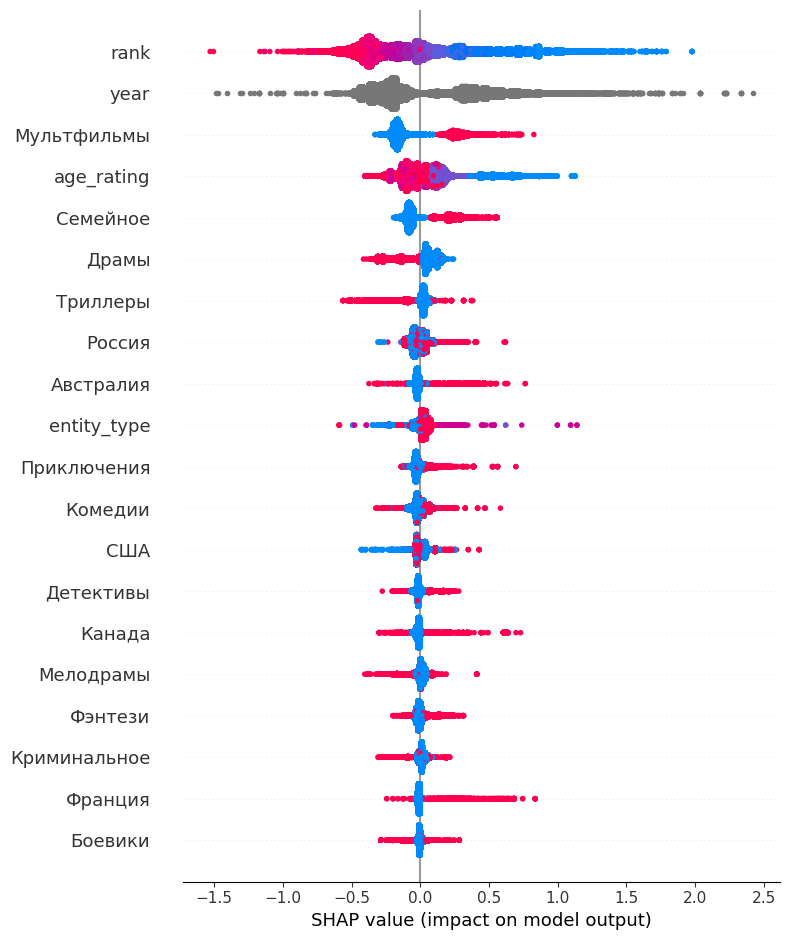

In [276]:
shap.summary_plot(shap_values, X_train_cbm, show = False, color_bar = False)

In [277]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test_cbm)

In [278]:
ens_test_pred = lr.predict_proba(blend.reshape(-1, 1))[:,1]

In [279]:
y_test_pred[:, 1]


array([0.42988855, 0.06087025, 0.19432526, ..., 0.07370756, 0.15143939,
       0.18300474])

In [280]:
print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.5f}")
print(f"ROC AUC score = {roc_auc_score(y_test, ens_test_pred):.5f}")

ROC AUC score = 0.75500
ROC AUC score = 0.75347


# TODO
- Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM seperately, LightFM + Ranker

In [281]:
def compute_metrics(df_true: pd.DataFrame, 
                    df_pred: pd.DataFrame, 
                    K: int, 
                    rank_col: str = 'rank') -> pd.DataFrame:

    result = pd.DataFrame(columns=['Metric', 'Value'])

    test_recs = df_true.set_index(['user_id', 'movie_id']).join(df_pred.set_index(['user_id', 'movie_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('user_id').nunique()

    for k in range(1, K + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result.loc[len(result.index)] = [f'Precision@{k}', (test_recs[hit_k] / k).sum() / users_count]

    result.loc[len(result.index)] = [f'MAP@{K}', (test_recs['cumulative_rank'] / test_recs['users_item_count']).sum() / users_count]
    result.loc[len(result.index)] = [f'MRR', test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()]
    
    return result

In [282]:
# we will focus on warm start - remove cold start users
global_test = global_test[global_test['user_id'].isin(local_train['user_id'].unique())]

In [283]:
top_N = 100

# let's make predictions for all users in global test
global_test_preds = pd.DataFrame({
    'user_id': global_test['user_id'].unique()
    })

# form user-known items
known_items = {user_id: item_id_gr['movie_id'].to_list() for user_id, item_id_gr in local_train[['user_id', 'movie_id']].groupby('user_id')}

In [284]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

global_test_preds['movie_id'] = global_test_preds['user_id'].map(mapper)
global_test_preds = global_test_preds.explode('movie_id').reset_index(drop=True)
global_test_preds['rank'] = global_test_preds.groupby('user_id').cumcount() + 1 

In [285]:
lfm_metrics = compute_metrics(local_test[['user_id', 'movie_id']],
                              test_preds, 
                              K=10)
lfm_metrics

,Metric,Value
0,Precision@1,0.084
1,Precision@2,0.077
2,Precision@3,0.072
3,Precision@4,0.067
4,Precision@5,0.062
5,Precision@6,0.059
6,Precision@7,0.056
7,Precision@8,0.053
8,Precision@9,0.051
9,Precision@10,0.049


In [286]:
global_test_lfm_ctb_preds = global_test_preds.copy()

# joins user features
# global_test_lfm_ctb_set = pd.merge(global_test_lfm_ctb_preds, 
#                                    users_data[['user_id'] + USER_FEATURES],
#                                    how='left', on=['user_id'])
# joins item features
global_test_lfm_ctb_set = pd.merge(global_test_lfm_ctb_preds, 
                                   movies_metadata[['movie_id'] + ITEM_FEATURES],
                                   how='left', on=['movie_id'])

global_test_lfm_ctb_set = global_test_lfm_ctb_set.fillna(global_test_lfm_ctb_set.mode().iloc[0])
global_test_lfm_ens_set = global_test_lfm_ctb_set.copy()

In [287]:
# Для cbm
global_test_lfm_ctb_set['year'] = global_test_lfm_ctb_set['release_world'].apply(lambda x: x.split('-')[0] if pd.isna(x) is False else x)
#Для ens
global_test_lfm_ens_set['year'] = global_test_lfm_ens_set['release_world'].apply(lambda x: x.split('-')[0] if pd.isna(x) is False else x)
global_test_lfm_ens_set = year_to_cat_transformer(global_test_lfm_ens_set, col='year')
global_test_lfm_ens_set['year_category'] = global_test_lfm_ens_set['year_category'].astype(int)

In [288]:
ctb_prediction = cbm_classifier.predict_proba(global_test_lfm_ctb_set.drop(ID_COLS + ['release_world'], axis=1, errors='ignore'))

global_test_lfm_ctb_preds['ctb_pred'] = ctb_prediction[:, 1]
global_test_lfm_ctb_preds.head()

,user_id,movie_id,rank,ctb_pred
0,58953,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,1,0.177
1,58953,91f9d892-a508-4962-91e9-abacd93e0830,2,0.183
2,58953,5a3bf8a0-3054-448b-b524-025abea0cac3,3,0.166
3,58953,fbc33563-88d0-464c-a517-2f1bf3bae0e1,4,0.067
4,58953,42f5cb31-f333-426c-a95b-8e106741de38,5,0.115


In [289]:
global_test_lfm_ctb_preds = global_test_lfm_ctb_preds.sort_values(by=['user_id', 'ctb_pred'], 
                                                                  ascending=[True, False])
global_test_lfm_ctb_preds['rank_ctb'] = global_test_lfm_ctb_preds.groupby('user_id').cumcount() + 1
global_test_lfm_ctb_preds.head(10)

,user_id,movie_id,rank,ctb_pred,rank_ctb
1198703,56250,7dcafba8-7fde-4e85-bf83-e65bada687eb,4,0.470,1
1198709,56250,886cdfce-027d-4375-8b0f-5f2c36661239,10,0.315,2
1198701,56250,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,2,0.253,3
1198716,56250,e3d7520c-be9c-4fd7-a62f-695b97c397eb,17,0.232,4
1198700,56250,91f9d892-a508-4962-91e9-abacd93e0830,1,0.205,5
1198794,56250,5bdf3c78-e3a1-4813-be53-1e67c0b639c4,95,0.197,6
1198731,56250,c6dcfd37-1104-472a-8968-3362f702b6bc,32,0.196,7
1198799,56250,09cc576b-e693-4155-af36-65c146ca6e75,100,0.170,8
1198717,56250,2160ce47-2962-4c87-9ccf-81d942ad84c8,18,0.159,9
1198729,56250,85ca7944-a8b9-4936-a1dd-1b0622f51482,30,0.150,10


In [290]:
lfm_cbm_metrics = compute_metrics(global_test[['user_id', 'movie_id']],
                                  global_test_lfm_ctb_preds, 
                                  K=10, 
                                  rank_col='rank_ctb')
lfm_cbm_metrics

,Metric,Value
0,Precision@1,0.052
1,Precision@2,0.048
2,Precision@3,0.044
3,Precision@4,0.041
4,Precision@5,0.038
5,Precision@6,0.036
6,Precision@7,0.034
7,Precision@8,0.033
8,Precision@9,0.032
9,Precision@10,0.031


## ENSEMBLE

In [291]:
X_pred_test = global_test_lfm_ens_set.drop(ID_COLS + ['release_world']+ ['year'], axis=1, errors='ignore')
ctb_prediction = ctb_prediction[:, 1]
rf_prediction = rf_classifier.predict_proba(X_pred_test)[:,1]
xg_prediction = xg.predict_proba(X_pred_test)[:,1]
ldb_prediction = model.predict(X_pred_test)
f_blend = (0.4 * ctb_prediction) + (0.2 * xg_prediction) + (0.2 * rf_prediction) + (0.2 * ldb_prediction)

In [292]:
global_test_lfm_ens_preds = global_test_preds.copy()
global_test_lfm_ens_preds['ens_pred'] = lr.predict_proba(f_blend.reshape(-1, 1))[:,1]
global_test_lfm_ens_preds.head()

,user_id,movie_id,rank,ens_pred
0,58953,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,1,0.150
1,58953,91f9d892-a508-4962-91e9-abacd93e0830,2,0.157
2,58953,5a3bf8a0-3054-448b-b524-025abea0cac3,3,0.153
3,58953,fbc33563-88d0-464c-a517-2f1bf3bae0e1,4,0.080
4,58953,42f5cb31-f333-426c-a95b-8e106741de38,5,0.104


In [293]:
global_test_lfm_ens_preds = global_test_lfm_ens_preds.sort_values(by=['user_id', 'ens_pred'], 
                                                                  ascending=[True, False])
global_test_lfm_ens_preds['rank_ens'] = global_test_lfm_ens_preds.groupby('user_id').cumcount() + 1
global_test_lfm_ens_preds.head(10)

,user_id,movie_id,rank,ens_pred,rank_ens
1198703,56250,7dcafba8-7fde-4e85-bf83-e65bada687eb,4,0.544,1
1198709,56250,886cdfce-027d-4375-8b0f-5f2c36661239,10,0.339,2
1198794,56250,5bdf3c78-e3a1-4813-be53-1e67c0b639c4,95,0.263,3
1198759,56250,05f4998d-3ef3-4daa-ba15-6fb1002bf40b,60,0.236,4
1198701,56250,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,2,0.212,5
1198711,56250,f40dfca2-27ef-40b3-9119-a20dfe965013,12,0.190,6
1198731,56250,c6dcfd37-1104-472a-8968-3362f702b6bc,32,0.186,7
1198700,56250,91f9d892-a508-4962-91e9-abacd93e0830,1,0.174,8
1198716,56250,e3d7520c-be9c-4fd7-a62f-695b97c397eb,17,0.168,9
1198799,56250,09cc576b-e693-4155-af36-65c146ca6e75,100,0.165,10


In [294]:
lfm_ens_metrics = compute_metrics(global_test[['user_id', 'movie_id']],
                                  global_test_lfm_ens_preds, 
                                  K=10, 
                                  rank_col='rank_ens')
print(lfm_cbm_metrics)
print(lfm_ens_metrics)

          Metric  Value
0    Precision@1  0.052
1    Precision@2  0.048
2    Precision@3  0.044
3    Precision@4  0.041
4    Precision@5  0.038
5    Precision@6  0.036
6    Precision@7  0.034
7    Precision@8  0.033
8    Precision@9  0.032
9   Precision@10  0.031
10        MAP@10  0.038
11           MRR  0.077
          Metric  Value
0    Precision@1  0.060
1    Precision@2  0.052
2    Precision@3  0.046
3    Precision@4  0.042
4    Precision@5  0.039
5    Precision@6  0.037
6    Precision@7  0.035
7    Precision@8  0.033
8    Precision@9  0.032
9   Precision@10  0.031
10        MAP@10  0.039
11           MRR  0.082
